<a href="https://colab.research.google.com/github/Umarabdul270/my_poject/blob/master/CarPriceModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

✓ Training data loaded: (188533, 13)
✓ Test data loaded: (125690, 12)

PREPROCESSING DATA
🔧 Applying feature engineering...
🔧 Handling missing values...
🔧 Encoding categorical variables...
🔧 Handling outliers...
   Removed 3401 extreme price outliers (1.8%)
🔧 Preparing final feature set...
   Final feature set: 17 features
   Training samples after cleaning: 183310
✓ Preprocessing completed!

MODEL TRAINING

🚀 Training LinearRegression...
   ✓ RMSE: $26,734.64
   ✓ R²: 0.3807
   ✓ MAE: $16,297.17

🚀 Training Ridge...
   ✓ RMSE: $26,734.64
   ✓ R²: 0.3807
   ✓ MAE: $16,297.17

🚀 Training RandomForestRegressor...
   ✓ RMSE: $25,414.26
   ✓ R²: 0.4403
   ✓ MAE: $14,389.27

🚀 Training GradientBoostingRegressor...
   ✓ RMSE: $24,628.69
   ✓ R²: 0.4744
   ✓ MAE: $13,757.74

👑 Best model based on RMSE: GradientBoostingRegressor

🔄 Retraining best model on full dataset...
✓ Retraining completed.

📊 Top 10 Most Important Features:
        feature  importance
         milage    0.605634
        

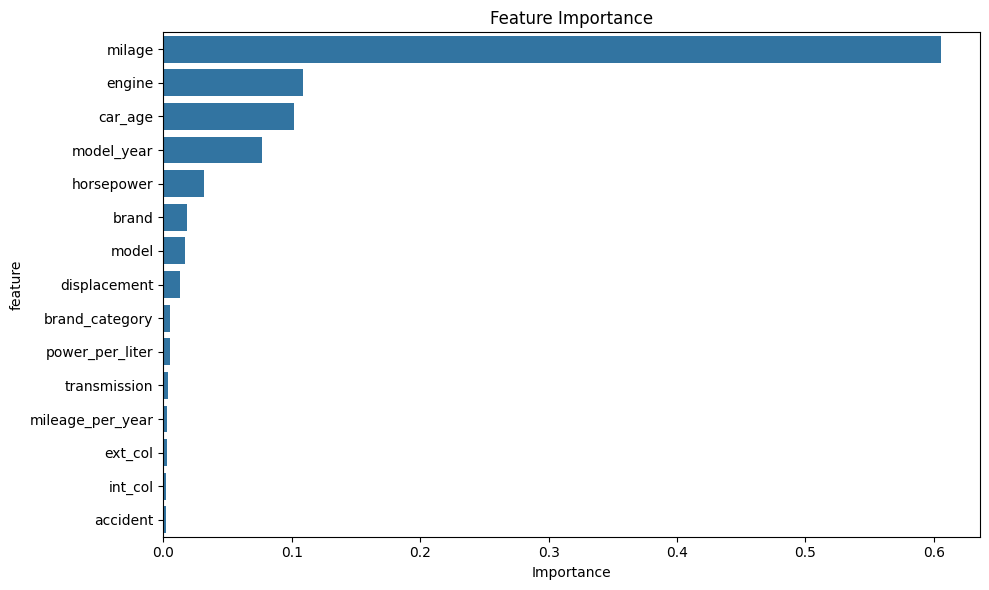


GENERATING PREDICTIONS
✓ Generated 125690 predictions
✓ Prediction range: $5,680.22 - $173,146.80
✓ Mean prediction: $39,336.56

✅ Submission file created: submission.csv
✓ Model saved to car_price_model.joblib


In [ ]:
# Import necessary models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

class CarPricePredictor:
    def __init__(self):
        self.label_encoders = {}
        self.feature_columns = None
        self.models = {}
        self.best_model = None
        self.scaler = None

    def load_data(self, train_path, test_path):
        """Load training and test datasets"""
        try:
            self.train_df = pd.read_csv(train_path)
            self.test_df = pd.read_csv(test_path)
            print(f"✓ Training data loaded: {self.train_df.shape}")
            print(f"✓ Test data loaded: {self.test_df.shape}")
            return True
        except Exception as e:
            print(f"✗ Error loading data: {e}")
            return False

    def exploratory_analysis(self):
        """Comprehensive EDA"""
        print("\n" + "="*50)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*50)

        # Basic info
        print("\n📊 Dataset Overview:")
        print(f"Training samples: {len(self.train_df)}")
        print(f"Features: {len(self.train_df.columns)-1}")
        print(f"Target: price")

        # Missing values analysis
        print("\n🔍 Missing Values Analysis:")
        missing_train = self.train_df.isnull().sum()
        missing_test = self.test_df.isnull().sum()

        missing_df = pd.DataFrame({
            'Train_Missing': missing_train,
            'Train_Percent': (missing_train / len(self.train_df)) * 100,
            'Test_Missing': missing_test,
            'Test_Percent': (missing_test / len(self.test_df)) * 100
        })
        print(missing_df[missing_df['Train_Missing'] > 0])

        # Target variable analysis
        print(f"\n🎯 Target Variable Statistics:")
        print(f"Mean price: ${self.train_df['price'].mean():,.2f}")
        print(f"Median price: ${self.train_df['price'].median():,.2f}")
        print(f"Price range: ${self.train_df['price'].min():,.2f} - ${self.train_df['price'].max():,.2f}")

        # Outlier detection
        Q1 = self.train_df['price'].quantile(0.25)
        Q3 = self.train_df['price'].quantile(0.75)
        IQR = Q3 - Q1
        outliers = len(self.train_df[(self.train_df['price'] < Q1 - 1.5*IQR) |
                                   (self.train_df['price'] > Q3 + 1.5*IQR)])
        print(f"Price outliers detected: {outliers} ({outliers/len(self.train_df)*100:.1f}%)")

        self._plot_distributions()

    def _plot_distributions(self):
        """Create visualization plots"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Price distribution
        sns.histplot(data=self.train_df, x='price', kde=True, ax=axes[0,0])
        axes[0,0].set_title('Price Distribution')
        axes[0,0].set_xlabel('Price ($)')

        # Log price distribution (to handle skewness)
        sns.histplot(data=self.train_df, x=np.log1p(self.train_df['price']), kde=True, ax=axes[0,1])
        axes[0,1].set_title('Log Price Distribution')
        axes[0,1].set_xlabel('Log(Price + 1)')

        # Price vs Year
        sns.scatterplot(data=self.train_df, x='model_year', y='price', alpha=0.5, ax=axes[1,0])
        axes[1,0].set_title('Price vs Model Year')

        # Price vs Mileage
        sns.scatterplot(data=self.train_df, x='milage', y='price', alpha=0.5, ax=axes[1,1])
        axes[1,1].set_title('Price vs Mileage')

        plt.tight_layout()
        plt.show()

    def feature_engineering(self, df, is_train=True):
        """Advanced feature engineering"""
        df = df.copy()

        # Age of car
        current_year = 2024
        df['car_age'] = current_year - df['model_year']

        # Extract horsepower from engine description
        def extract_horsepower(engine_str):
            if pd.isna(engine_str):
                return 0
            match = re.search(r'(\d+\.?\d*)HP', str(engine_str))
            return float(match.group(1)) if match else 0

        df['horsepower'] = df['engine'].apply(extract_horsepower)

        # Extract engine displacement
        def extract_displacement(engine_str):
            if pd.isna(engine_str):
                return 0
            match = re.search(r'(\d+\.?\d*)L', str(engine_str))
            return float(match.group(1)) if match else 0

        df['displacement'] = df['engine'].apply(extract_displacement)

        # Power to weight ratio (approximation using displacement)
        df['power_per_liter'] = df['horsepower'] / (df['displacement'] + 1)

        # Mileage per year
        df['mileage_per_year'] = df['milage'] / (df['car_age'] + 1)

        # Brand value categories (based on luxury/economy segments)
        luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 'Tesla', 'Genesis']
        premium_brands = ['Acura', 'Infiniti', 'Cadillac', 'Lincoln', 'Volvo']

        df['brand_category'] = df['brand'].apply(lambda x:
            'Luxury' if x in luxury_brands else
            'Premium' if x in premium_brands else 'Standard')

        return df

    def preprocess_data(self):
        """Robust preprocessing pipeline"""
        print("\n" + "="*50)
        print("PREPROCESSING DATA")
        print("="*50)

        # Apply feature engineering
        print("🔧 Applying feature engineering...")
        self.train_processed = self.feature_engineering(self.train_df, is_train=True)
        self.test_processed = self.feature_engineering(self.test_df, is_train=False)

        # Handle missing values strategically
        print("🔧 Handling missing values...")
        self._handle_missing_values()

        # Encode categorical variables
        print("🔧 Encoding categorical variables...")
        self._encode_categorical_variables()

        # Remove outliers from training data
        print("🔧 Handling outliers...")
        self._handle_outliers()

        # Prepare features
        print("🔧 Preparing final feature set...")
        self._prepare_features()

        print("✓ Preprocessing completed!")

    def _handle_missing_values(self):
        """Strategic missing value handling"""
        # Numerical columns - use median
        numerical_cols = ['model_year', 'milage', 'horsepower', 'displacement']
        for col in numerical_cols:
            if col in self.train_processed.columns:
                median_val = self.train_processed[col].median()
                self.train_processed[col].fillna(median_val, inplace=True)
                self.test_processed[col].fillna(median_val, inplace=True)

        # Categorical columns - use mode or specific logic
        categorical_cols = ['fuel_type', 'accident', 'clean_title']
        for col in categorical_cols:
            if col in self.train_processed.columns:
                if col == 'accident':
                    # For accident, missing likely means no accident
                    self.train_processed[col].fillna('None reported', inplace=True)
                    self.test_processed[col].fillna('None reported', inplace=True)
                elif col == 'clean_title':
                    # For clean_title, missing is ambiguous, use most common
                    mode_val = self.train_processed[col].mode()[0] if len(self.train_processed[col].mode()) > 0 else 'Yes'
                    self.train_processed[col].fillna(mode_val, inplace=True)
                    self.test_processed[col].fillna(mode_val, inplace=True)
                else:
                    mode_val = self.train_processed[col].mode()[0] if len(self.train_processed[col].mode()) > 0 else 'Unknown'
                    self.train_processed[col].fillna(mode_val, inplace=True)
                    self.test_processed[col].fillna(mode_val, inplace=True)

    def _encode_categorical_variables(self):
        """Consistent categorical encoding"""
        categorical_cols = self.train_processed.select_dtypes(include='object').columns
        categorical_cols = [col for col in categorical_cols if col not in ['price', 'id']]

        for col in categorical_cols:
            le = LabelEncoder()

            # Combine train and test for consistent encoding
            combined_values = pd.concat([self.train_processed[col], self.test_processed[col]]).astype(str)
            le.fit(combined_values)

            self.train_processed[col] = le.transform(self.train_processed[col].astype(str))
            self.test_processed[col] = le.transform(self.test_processed[col].astype(str))

            self.label_encoders[col] = le

    def _handle_outliers(self):
        """Remove extreme outliers from training data"""
        # Price outliers
        Q1 = self.train_processed['price'].quantile(0.01)
        Q99 = self.train_processed['price'].quantile(0.99)

        initial_size = len(self.train_processed)
        self.train_processed = self.train_processed[
            (self.train_processed['price'] >= Q1) &
            (self.train_processed['price'] <= Q99)
        ]
        removed = initial_size - len(self.train_processed)
        print(f"   Removed {removed} extreme price outliers ({removed/initial_size*100:.1f}%)")

        # Mileage outliers
        Q99_mileage = self.train_processed['milage'].quantile(0.99)
        self.train_processed = self.train_processed[self.train_processed['milage'] <= Q99_mileage]

    def _prepare_features(self):
        """Prepare final feature matrix"""
        # Define feature columns (exclude target and id)
        exclude_cols = ['id', 'price'] if 'price' in self.train_processed.columns else ['id']
        self.feature_columns = [col for col in self.train_processed.columns if col not in exclude_cols]

        # Prepare training data
        self.X = self.train_processed[self.feature_columns]
        self.y = self.train_processed['price']

        # Prepare test data
        self.X_test = self.test_processed[self.feature_columns]

        print(f"   Final feature set: {len(self.feature_columns)} features")
        print(f"   Training samples after cleaning: {len(self.X)}")

    def train_models(self):
        """Train multiple regression models and evaluate"""
        print("\n" + "="*50)
        print("MODEL TRAINING")
        print("="*50)

        # Split training data
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        models_to_train = {
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(alpha=1.0), # Added Ridge
            'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # Added RandomForestRegressor
            'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Added GradientBoostingRegressor
        }

        self.models = {}
        best_rmse = float('inf')
        best_model_name = None

        for name, model in models_to_train.items():
            print(f"\n🚀 Training {name}...")
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                r2 = r2_score(y_val, y_pred)
                mae = mean_absolute_error(y_val, y_pred)

                self.models[name] = {'model': model, 'rmse': rmse, 'r2': r2, 'mae': mae}

                print(f"   ✓ RMSE: ${rmse:,.2f}")
                print(f"   ✓ R²: {r2:.4f}")
                print(f"   ✓ MAE: ${mae:,.2f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model_name = name
                    self.best_model = model

            except Exception as e:
                print(f"   ✗ Error training {name}: {e}")
                self.models[name] = {'model': None, 'rmse': None, 'r2': None, 'mae': None, 'error': str(e)}


        print(f"\n👑 Best model based on RMSE: {best_model_name}")

        # Retrain the best model on the full dataset
        if self.best_model:
            print("\n🔄 Retraining best model on full dataset...")
            try:
                self.best_model.fit(self.X, self.y)
                print("✓ Retraining completed.")
            except Exception as e:
                 print(f"✗ Error retraining best model: {e}")
                 self.best_model = None # Invalidate best_model if retraining fails


        return self.models


    def analyze_feature_importance(self):
        """Analyze and visualize feature importance for tree-based models"""
        if isinstance(self.best_model, (RandomForestRegressor, GradientBoostingRegressor)):
            print("\n📊 Top 10 Most Important Features:")
            importances = self.best_model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(feature_importance.head(10).to_string(index=False))

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

            return feature_importance
        elif hasattr(self.best_model, 'coef_'):
            # For linear models, show absolute coefficients
            print("\n📊 Top 10 Most Important Features (Absolute Coefficient):")
            importances = self.best_model.coef_
            feature_importance = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': np.abs(importances)
            }).sort_values('importance', ascending=False)

            print(feature_importance.head(10).to_string(index=False))

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
            plt.title('Feature Importance (Absolute Coefficient)')
            plt.xlabel('Absolute Coefficient Value')
            plt.tight_layout()
            plt.show()

            return feature_importance

        else:
            print("⚠️  Feature importance not available for this model type")
            return None

    def generate_predictions(self):
        """Generate predictions for test set"""
        print("\n" + "="*50)
        print("GENERATING PREDICTIONS")
        print("="*50)

        if self.best_model is None:
             print("✗ No best model available to make predictions.")
             return None

        # Make predictions
        predictions = self.best_model.predict(self.X_test)

        # Create submission DataFrame
        submission = pd.DataFrame({
            'id': self.test_df['id'],
            'price': predictions
        })

        print(f"✓ Generated {len(predictions)} predictions")
        print(f"✓ Prediction range: ${predictions.min():,.2f} - ${predictions.max():,.2f}")
        print(f"✓ Mean prediction: ${predictions.mean():,.2f}")

        return submission

    def save_model(self, filepath):
        """Save the trained model"""
        if self.best_model:
            model_data = {
                'model': self.best_model,
                'feature_columns': self.feature_columns,
                'label_encoders': self.label_encoders
            }
            joblib.dump(model_data, filepath)
            print(f"✓ Model saved to {filepath}")
        else:
            print("✗ No best model available to save.")


# Usage Example
def main():
    # Initialize predictor
    predictor = CarPricePredictor()

    # Load data
    if not predictor.load_data('/content/train.csv',
                             '/content/test.csv'): # Using test.csv for test data
        return

    # Exploratory analysis
    # predictor.exploratory_analysis() # Skipping EDA in main for brevity after initial run

    # Preprocess data
    predictor.preprocess_data()

    # Train models
    results = predictor.train_models()

    # Analyze feature importance
    feature_importance = predictor.analyze_feature_importance()

    # Generate predictions
    submission = predictor.generate_predictions()

    # Save results
    if submission is not None:
        submission.to_csv('submission.csv', index=False)
        print("\n✅ Submission file created: submission.csv")

    # Save model
    predictor.save_model('car_price_model.joblib')

    return predictor, submission

# Run the improved pipeline
if __name__ == "__main__":
    predictor, submission = main()

## Hyperparameter tuning

### Subtask:
Perform thorough hyperparameter tuning for the best-performing model (GradientBoostingRegressor) using GridSearchCV to find optimal parameters that minimize RMSE.


**Reasoning**:
Perform hyperparameter tuning for GradientBoostingRegressor using GridSearchCV to find optimal parameters that minimize RMSE.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

print("\n" + "="*50)
print("HYPERPARAMETER TUNING (GradientBoostingRegressor)")
print("="*50)

# Define the parameter grid for GradientBoostingRegressor
# Starting with a small range for faster execution
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 4]
}

# Instantiate the GradientBoostingRegressor model
gbr = GradientBoostingRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', # Minimize RMSE
                           cv=3, # Using 3-fold cross-validation for quicker tuning
                           n_jobs=-1, verbose=2)

print("🚀 Starting GridSearchCV...")

# Fit GridSearchCV to the training data
grid_search.fit(predictor.X, predictor.y)

# Print the best hyperparameters and best score
print("\n✅ GridSearchCV completed.")
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation RMSE: {-grid_search.best_score_:.2f}") # Negate the score for RMSE

# Update the best model in the predictor object
predictor.best_model = grid_search.best_estimator_
print("\n🔄 Best model updated with tuned GradientBoostingRegressor.")

# Re-evaluate the best model on the full training data (optional, but good practice)
# This step is already handled in train_models by retraining the selected best_model
# We can skip explicit retraining here if the best_estimator_ from GridSearchCV
# is used directly for predictions later. The current setup retrains self.best_model
# on the full data after GridSearchCV finds the best estimator.


HYPERPARAMETER TUNING (GradientBoostingRegressor)
🚀 Starting GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ GridSearchCV completed.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 200}
Best cross-validation RMSE: 24406.96

🔄 Best model updated with tuned GradientBoostingRegressor.


In [ ]:
# Generate predictions using the tuned model
submission = predictor.generate_predictions()

# Save results
if submission is not None:
    submission.to_csv('submission.csv', index=False)
    print("\n✅ Submission file created: submission.csv")

# Save the tuned model
predictor.save_model('tuned_car_price_model.joblib')


GENERATING PREDICTIONS
✓ Generated 125690 predictions
✓ Prediction range: $4,660.10 - $182,232.47
✓ Mean prediction: $39,351.96

✅ Submission file created: submission.csv
✓ Model saved to tuned_car_price_model.joblib


In [ ]:
import pandas as pd

try:
    submission_df = pd.read_csv('submission.csv')
    print("Contents of submission.csv:")
    display(submission_df)
except FileNotFoundError:
    print("Error: submission.csv not found. Please make sure you have run the code to generate the submission file.")
except Exception as e:
    print(f"An error occurred while reading submission.csv: {e}")

Contents of submission.csv:


,id,price
0,188533,17395.232219
1,188534,65639.596848
2,188535,50906.622578
3,188536,21560.373618
4,188537,31859.612572
...,...,...
125685,314218,27972.761401
125686,314219,44349.315619
125687,314220,21756.110101
125688,314221,16417.526985
